##Import Libraries

In [ ]:
!wget https://github.com/dejavu-fonts/dejavu-fonts/blob/master/ttf/DejaVuSans.ttf?raw=true -O DejaVuSans.ttf

--2025-09-09 12:30:39--  https://github.com/dejavu-fonts/dejavu-fonts/blob/master/ttf/DejaVuSans.ttf?raw=true
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-09-09 12:30:40 ERROR 404: Not Found.



In [ ]:
# Install important libraries
!pip install nltk wordcloud --quiet

# Import data handling and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NLP preprocessing
import nltk
import re
import string
from wordcloud import WordCloud
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# Machine Learning tools
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,  # <-- this is the missing one
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)
from itertools import product
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve

warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#Loading the Reddit Depression Dataset

In [ ]:
# Loading the raw dataset
df_full = pd.read_csv('reddit_depression_dataset.csv', engine='python', on_bad_lines='skip', encoding='latin-1')

In [ ]:
print("Dataset shape:", df_full.shape)

Dataset shape: (2470775, 8)


In [ ]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2470775 entries, 0 to 2470774
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Unnamed: 0    object 
 1   subreddit     object 
 2   title         object 
 3   body          object 
 4   upvotes       float64
 5   created_utc   float64
 6   num_comments  float64
 7   label         float64
dtypes: float64(4), object(4)
memory usage: 150.8+ MB


In [ ]:
df_full.head()

,Unnamed: 0,subreddit,title,body,upvotes,created_utc,num_comments,label
0,47951,DeepThoughts,Deep thoughts underdog,"Only when we start considering ourselves, the ...",4.0,1.405309e+09,NaN,0.0
1,47952,DeepThoughts,"I like this sub, there's only two posts yet I ...",Anyway: Human Morality is a joke so long as th...,4.0,1.410568e+09,1.0,0.0
2,47957,DeepThoughts,Rebirth!,Hello. \nI am the new guy in charge here (Besi...,6.0,1.416458e+09,1.0,0.0
3,47959,DeepThoughts,"""I want to be like water. I want to slip throu...",NaN,25.0,1.416512e+09,2.0,0.0
4,47960,DeepThoughts,Who am I?,You could take any one cell in my body and kil...,5.0,1.416516e+09,4.0,0.0


In [ ]:
df_full.tail()

,Unnamed: 0,subreddit,title,body,upvotes,created_utc,num_comments,label
2470770,10742224,depression,Alone as usual,I just argued with my mom an hour ago; she alw...,9.0,1.672529e+09,6.0,1.0
2470771,10742230,depression,Help needed urgently!,OK basically non of my friend's or family invi...,5.0,1.672530e+09,7.0,1.0
2470772,10742232,depression,I know what your thinking,Don't do It. Not today. Its gonna be ok if you...,10.0,1.672530e+09,8.0,1.0
2470773,10742243,depression,how do I stop having such a cynical view on ma...,"So I don't know, I've recently realized that t...",8.0,1.672531e+09,9.0,1.0
2470774,10742244,depression,2022 year in review:,It sucked.\n\nGod help us all,13.0,1.672531e+09,2.0,1.0


#Drop Missing Values and Filter Labels

In [ ]:
# Drop rows with missing title/body/label
df_full = df_full.dropna(subset=['title', 'body', 'label']).copy()

In [ ]:
# Keep only valid binary labels: 0 (not depressed), 1 (depressed)
df_full = df_full[df_full['label'].isin([0, 1])]
df_full['label'] = df_full['label'].astype(int)

#Combine Title and Body into One Text Field

In [ ]:
# Combine 'title' and 'body' into a single 'text' field
df_full['text'] = df_full['title'].astype(str) + ' ' + df_full['body'].astype(str)


#Text Cleaning

In [ ]:
# Function to clean the text
def clean_text(text):
    text = text.lower()  # convert to lowercase
    text = re.sub(r"http\S+|www.\S+|@\w+", "", text)  # remove URLs and mentions
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # remove punctuation and digits
    text = " ".join([word for word in text.split() if word not in stop_words])  # remove stopwords
    return text

In [ ]:
# Apply the function
df_full['clean_text'] = df_full['text'].apply(clean_text)


In [ ]:
# Drop empty cleaned texts
df_full = df_full[df_full['clean_text'].str.strip() != '']


#Post Length Distribution

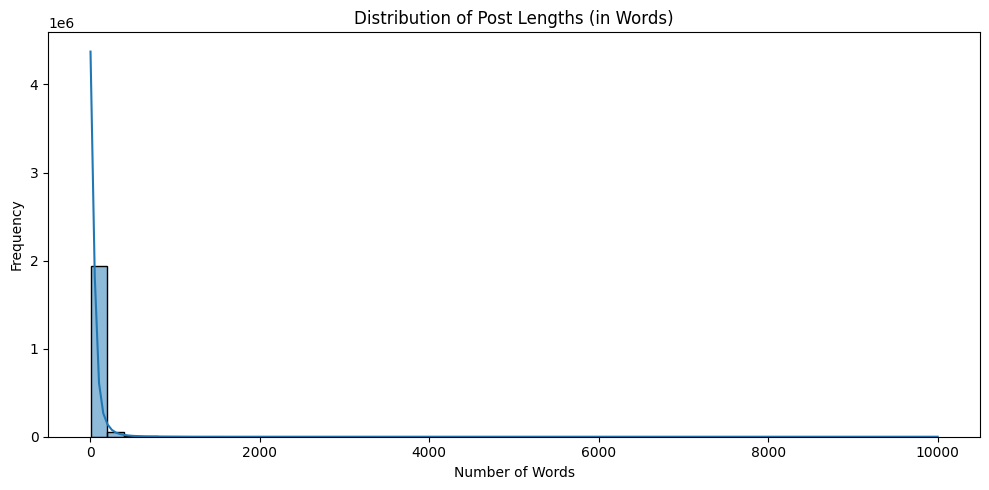

In [ ]:
# Add a column to show length of each post
df_full['post_length'] = df_full['clean_text'].apply(lambda x: len(x.split()))

# Visualize distribution
plt.figure(figsize=(10, 5))
sns.histplot(data=df_full, x='post_length', bins=50, kde=True)
plt.title("Distribution of Post Lengths (in Words)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


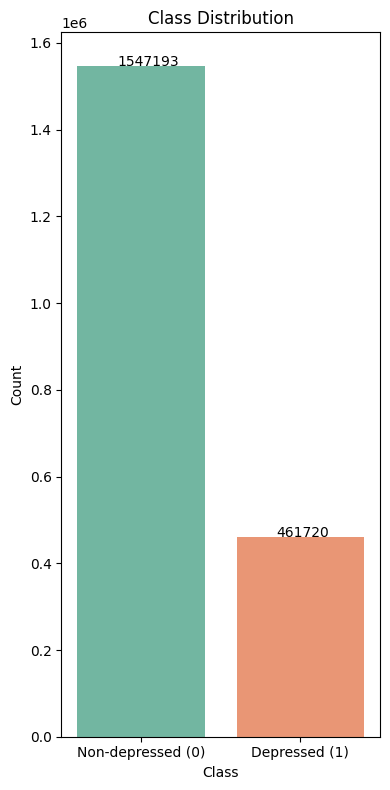

In [ ]:
# Class balance
plt.figure(figsize=(4,8))
ax = sns.countplot(data=df_full, x='label', palette='Set2')
ax.set_xticklabels(['Non‑depressed (0)', 'Depressed (1)'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x()+0.25, p.get_height()+3))
plt.tight_layout()
plt.show()

In [ ]:
# Quick ratio print
ratio = df_full['label'].value_counts(normalize=True).rename({0:'Non-depressed',1:'Depressed'})
print('Class ratio:\n', ratio.round(3))

Class ratio:
 label
Non-depressed    0.77
Depressed        0.23
Name: proportion, dtype: float64


In [ ]:
assert 'subreddit' in df_full.columns, "Expected a 'subreddit' column in df_full."
assert 'text' in df_full.columns and 'label' in df_full.columns, "Expected 'text' and 'label' columns."

# 1) See subreddit sizes (use this to choose H)
sub_sizes = df_full['subreddit'].value_counts()
print("Top 10 subreddits by count:\n", sub_sizes.head(10), "\n")

# 2) CHOOSE THE HELD-OUT SUBREDDIT
heldout_subs = ['r/depression']

# 3) Partition into H (held-out) and T (training pool)
mask_H = df_full['subreddit'].isin(heldout_subs)
df_H = df_full[mask_H].copy()
df_T = df_full[~mask_H].copy()

print(f"Held-out subreddits (H): {heldout_subs}")
print(f"H shape: {df_H.shape}, T shape: {df_T.shape}")

# 4) Build train/val from T (stratified), leave H untouched
from sklearn.model_selection import train_test_split

X_T = df_T['text'].values
y_T = df_T['label'].values

X_train, X_val, y_train, y_val = train_test_split(
    X_T, y_T, test_size=0.20, random_state=42, stratify=y_T
)


X_shift = df_H['text'].values
y_shift = df_H['label'].values

# 6) Log distributions for transparency (paste into report if needed)
import numpy as np
def dist(y):
    vc = pd.Series(y).value_counts(normalize=True).sort_index()
    return {int(k): float(v) for k,v in vc.items()}

print("\nClass distribution (T → train):", dist(y_train))
print("Class distribution (T → val)  :", dist(y_val))
print("Class distribution (H → test) :", dist(y_shift))

# 7) Save names for the report (so you can cite them in Section 4.9)
with open('heldout_domains.txt','w',encoding='utf-8') as f:
    f.write("Held-out subreddits (H): " + ", ".join(heldout_subs) + "\n")
    f.write("Training pool excludes H (T).")


Top 10 subreddits by count:
 subreddit
teenagers       1525146
depression       282380
SuicideWatch     179340
happy             15205
DeepThoughts       6842
Name: count, dtype: int64 

Held-out subreddits (H): ['r/depression']
H shape: (0, 11), T shape: (2008913, 11)

Class distribution (T → train): {0: 0.7701642057580905, 1: 0.2298357942419095}
Class distribution (T → val)  : {0: 0.7701644917779, 1: 0.2298355082221}
Class distribution (H → test) : {}


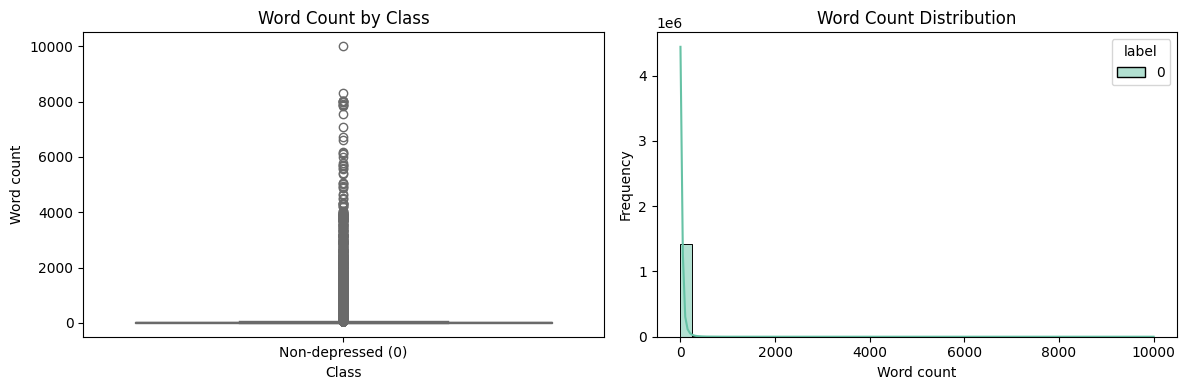

        word_len                                                char_len  \
           count   mean    std  min  25%   50%   75%      max      count   
label                                                                      
0      1437315.0  31.32  72.21  1.0  9.0  16.0  31.0  10001.0  1437315.0   

                                                        
         mean     std  min   25%   50%    75%      max  
label                                                   
0      200.07  488.02  1.0  55.0  96.0  197.0  40283.0  


In [ ]:
# Basic text length features ---
df_full['char_len'] = df_full['clean_text'].str.len()
df_full['word_len'] = df_full['clean_text'].str.split().apply(len)

fig, axes = plt.subplots(1, 2, figsize=(12,4))

sns.boxplot(data=df_full, x='label', y='word_len', palette='Set3', ax=axes[0])
axes[0].set_xticklabels(['Non‑depressed (0)', 'Depressed (1)'])
axes[0].set_title('Word Count by Class'); axes[0].set_xlabel('Class'); axes[0].set_ylabel('Word count')

sns.histplot(data=df_full, x='word_len', hue='label', bins=40, kde=True, palette='Set2', ax=axes[1])
axes[1].set_title('Word Count Distribution'); axes[1].set_xlabel('Word count'); axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print(df_full[['word_len','char_len','label']].groupby('label').describe().round(2))


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def plot_top_words(texts, title, top_n=25):
    vec = CountVectorizer(stop_words='english', max_features=5000)
    X = vec.fit_transform(texts)
    freqs = np.asarray(X.sum(axis=0)).ravel()
    vocab = np.array(vec.get_feature_names_out())
    idx = freqs.argsort()[::-1][:top_n]
    top_words = vocab[idx]
    top_freqs = freqs[idx]

    plt.figure(figsize=(10,6))
    sns.barplot(x=top_freqs, y=top_words, orient='h', palette='viridis')
    plt.title(title); plt.xlabel('Frequency'); plt.ylabel('Word')
    plt.tight_layout(); plt.show()

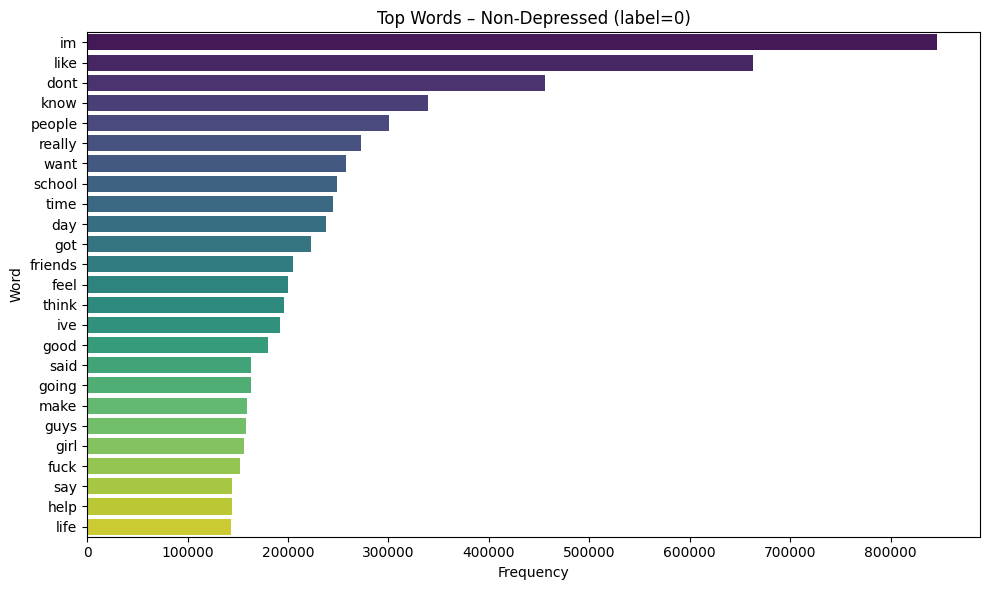

In [ ]:
# Top words by class
# plot_top_words(df_full.loc[df_full['label']==1, 'clean_text'], 'Top Words – Depressed (label=1)') # Commented out as there are no data points with label 1 in df_full
plot_top_words(df_full.loc[df_full['label']==0, 'clean_text'], 'Top Words – Non‑Depressed (label=0)')

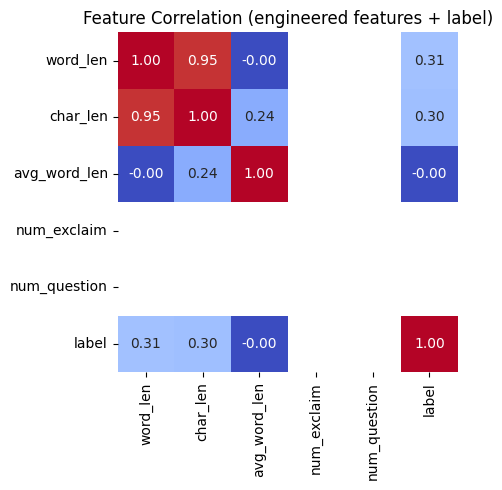

,label
label,1.000000
word_len,0.310539
char_len,0.302718
avg_word_len,-0.002556
num_exclaim,NaN
num_question,NaN


In [ ]:
# Extra lightweight features
df_full['avg_word_len'] = df_full['clean_text'].apply(
    lambda s: np.mean([len(w) for w in s.split()]) if s.split() else 0
)
df_full['num_exclaim'] = df_full['clean_text'].str.count('!')
df_full['num_question'] = df_full['clean_text'].str.count(r'\?')

corr_cols = ['word_len','char_len','avg_word_len','num_exclaim','num_question','label']
corr = df_full[corr_cols].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar=False)
plt.title('Feature Correlation (engineered features + label)')
plt.tight_layout()
plt.show()

corr['label'].sort_values(ascending=False)


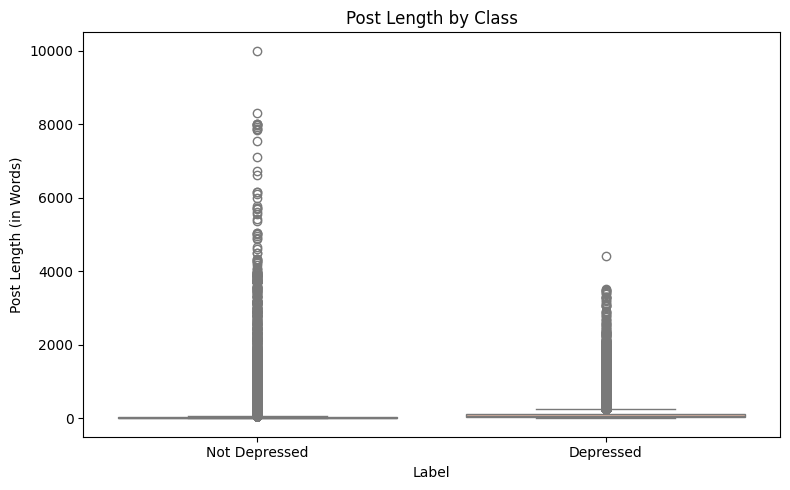

In [ ]:
# Compare how long posts are in each class
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_full, x='label', y='post_length', palette='coolwarm')
plt.xticks([0, 1], ['Not Depressed', 'Depressed'])
plt.title("Post Length by Class")
plt.xlabel("Label")
plt.ylabel("Post Length (in Words)")
plt.tight_layout()
plt.show()

In [ ]:
# Check if longer posts are more likely to be depressed
correlation = df_full[['post_length', 'label']].corr()
print("Correlation matrix:\n", correlation)


Correlation matrix:
              post_length     label
post_length     1.000000  0.310539
label           0.310539  1.000000


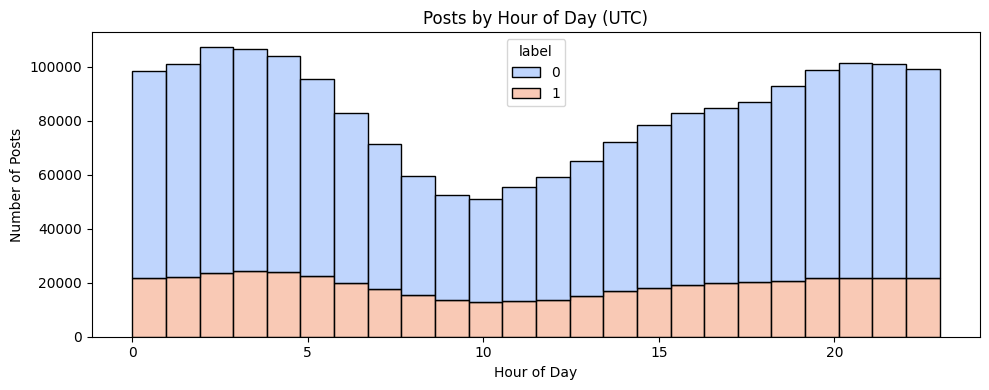

In [ ]:
# Convert timestamp and analyze time of posting
if 'created_utc' in df_full.columns:
    df_full['created_utc'] = pd.to_datetime(df_full['created_utc'], unit='s')
    df_full['hour'] = df_full['created_utc'].dt.hour

    plt.figure(figsize=(10, 4))
    sns.histplot(data=df_full, x='hour', bins=24, kde=False, hue='label', palette='coolwarm', multiple='stack')
    plt.title("Posts by Hour of Day (UTC)")
    plt.xlabel("Hour of Day")
    plt.ylabel("Number of Posts")
    plt.tight_layout()
    plt.show()


#Checking the Class Distribution Before Balancing

In [ ]:
label_counts = df_full['label'].value_counts()
label_ratio = df_full['label'].value_counts(normalize=True)

print("Class counts:\n", label_counts)
print("\nClass ratio:\n", label_ratio.round(3))


Class counts:
 label
0    1547193
1     461720
Name: count, dtype: int64

Class ratio:
 label
0    0.77
1    0.23
Name: proportion, dtype: float64


#Apply Balancing

In [ ]:
# Separate majority and minority classes
df_majority = df_full[df_full['label'] == 0]
df_minority = df_full[df_full['label'] == 1]

In [ ]:
# Random oversample the minority class
df_minority_oversampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

In [ ]:
# Combine back into a balanced DataFrame
df_balanced = pd.concat([df_majority, df_minority_oversampled])


In [ ]:
# Shuffle to mix classes
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# Check new distribution
print("Balanced class counts:\n", df_balanced['label'].value_counts())

Balanced class counts:
 label
0    1547193
1    1547193
Name: count, dtype: int64


 #Train–Validation–Test Split

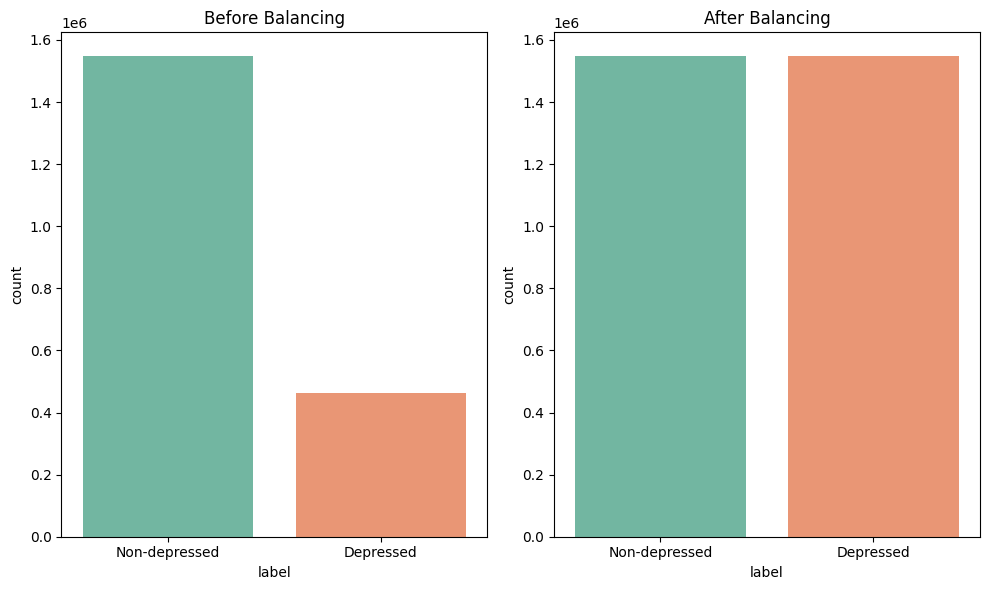

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,6))

sns.countplot(data=df_full, x='label', palette='Set2', ax=axes[0])
axes[0].set_title("Before Balancing")
axes[0].set_xticklabels(['Non-depressed','Depressed'])

sns.countplot(data=df_balanced, x='label', palette='Set2', ax=axes[1])
axes[1].set_title("After Balancing")
axes[1].set_xticklabels(['Non-depressed','Depressed'])

plt.tight_layout()
plt.show()


In [ ]:
# Features and labels
X = df_balanced['clean_text']
y = df_balanced['label']

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
# Further split training set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

In [ ]:
print(f"Train set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Train set: 1980406 samples
Validation set: 495102 samples
Test set: 618878 samples


In [ ]:
print("Train distribution:\n", y_train.value_counts(normalize=True).round(3))
print("\nValidation distribution:\n", y_val.value_counts(normalize=True).round(3))
print("\nTest distribution:\n", y_test.value_counts(normalize=True).round(3))

Train distribution:
 label
0    0.5
1    0.5
Name: proportion, dtype: float64

Validation distribution:
 label
0    0.5
1    0.5
Name: proportion, dtype: float64

Test distribution:
 label
1    0.5
0    0.5
Name: proportion, dtype: float64
